In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving img1.png to img1.png
User uploaded file "img1.png" with length 173712 bytes


In [0]:
!mkdir imgs
!mv ./img1.png imgs

In [8]:
!ls imgs

img1.png




---


# A guide on implementing a Quantum Neuron through Qiskit and IBM Q Experience

---

\* *The following tutorial is based on Tacchino, F., Macchiavello, C., Gerace, D. et al. An artificial neuron implemented on an actual quantum processor. npj Quantum Inf 5, 26 (2019) doi:10.1038/s41534-019-0140-4*


## Introduction

---

Traditional nuerual networks we see today are composed of tiny units called neurons. Theses neurons or perceptrons have a very simple function and can be described as follows :


> For a given set of input values and weights, first compute the inner product, and then apply a function(prefereably non linear) to this value. Threshold this value to generate a prediction

To implement this on a quantum computer, we first need to map a classical input to a quantum state. For the purpose of this project, the input and weight values will be limited to $K$ dimensional vectors with values $\{1,-1\}

## Encoding

To encode our classical states into quantum ones, we will multiply the $i^{th}$ value of the vector to $i{th}$ basis state of an $\log_{2}(K)$ qbit system

This encoding can be performed by applying a unitary transformation of the $|0>^{n}$ state. A naive algorithm for this encoding would be to perform a series of bit flips on the input values. This can be shown to be very expensive in terms of number of gates required and scales poorly with the number of qbits.

A the HSGS subroutine which we will implement is a better version of it and scales well

## Inner Product

To compute the inner product, we will chose the weight encoding unitary map in such a way that the required inner product will be stored inside the $|K-1>$ basis state

<img src="img1.png" alt="Drawing" style="width: 500px;"/>

Importing required libraries

In [6]:
 %matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *

from qiskit.circuit import Gate
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from qiskit.aqua.circuits.gates import mcrz 
simulator = Aer.get_backend('qasm_simulator')


To efficiently write an input state, we map the K bit vector to a decimal number, binary representation of which is formed by  mapping $-1$ to $1$ and $1$ to $0$

In [4]:
def num2bin(num, width):
    bin_ = np.binary_repr(num, width = width)
    ret = np.zeros(width)
    for i,ch in enumerate(bin_):
        ret[i] = int(ch)
    ret = np.power(-1,ret)

    return ret

## HSGS State Encoding
---

This algorithm takes a series of iterative steps that are described below. 
First, we check whether there is any component with only one qubit in state $|1〉$ (i.e. of the form $|0…010…0〉$) requiring a −1 factor, in the representation of $|ψi〉$ on the computational basis. If so, the corresponding single qubit Z gate is applied by targeting the only qubit in state $|1〉$. Notice that this might introduce additional −1 factors in front of states with more than one qubit in state $|1〉$. Then, for $p = 2, …, N$, we consider the components of the computational basis with exactly p qubits in state $|1〉$. For each of them, an additional $−1$ sign is introduced in front of its current amplitude (if it is needed and it was not previously introduced) by applying the corresponding CpZ between the p qubits in state $|1〉$. Similarly, if an unwanted sign is already present due to a previous step, this can be easily removed by applying the same CpZ. Since CpZ acts non trivially only on the manifold with p or more qubits being in state $|1〉$, the signs of all the elements with a lower number of $|1〉$ components are left unchanged

Now to know the locations of the $CpZ$ gates for each input combination, we can precompute them and call them when required in the encoding algorithm. This can be done classically

## Creating the ultimate lookup table


In [7]:
N_max = 8 #Maximum number of qbits
ltable = np.empty(N_max, dtype = object)

Max = N_max
DP = np.empty((Max,Max), dtype = object)
for i in range(Max):
    for j in range(Max):
        DP[i,j] = np.array([], dtype = '<U5')
str_ = ""

for len in range(Max):
    
    DP[len][0] = np.append(DP[len][0], np.copy(str_))
    str_ = str_ + "0"


tt = Max-1
for len in range(tt+1):
    for n in range(1,len+1):

#         // prefix 0 to all combinations of length len-1  
#         // with n ones 

        for str_ in DP[len-1][n]:
            DP[len][n] = np.append(DP[len][n], "0" + str_)

#         // prefix 1 to all combinations of length len-1  
#         // with n-1 ones 
        for str_ in DP[len-1][n-1]:
            DP[len][n] = np.append(DP[len][n], "1" + str_) 


for t in range(N_max-2):
    
    N = t
    combinations = {}
    
    for i in range(1,2**N):
        combinations[i] = {2**N - 1}
    ones = np.zeros(N)
    temp = 1
    
    for i in range(N):
        ones[i] = temp
        temp *= 2  
        
    for i in range(2**N - 1,  0, -1):
        for j in range(N):
            or_ = np.bitwise_or(int(i),int(ones[j]))
    #         print(or_)
            combinations[i].add(or_)
            combinations[i].update(combinations[or_])
            
    temp = []
    for n in range(1,t+1):
        temp1 = []
        for str_ in DP[t][n]:
#             print(int(str_,2) ," "),
            temp1.append(list(combinations[int(str_,2)]))
        temp.append(temp1)
        
    ltable[t] = temp




In [8]:
## Example of calling the lookup table

t = 1
n_qbits = 4
for i in ltable[n_qbits]:
    print(t, ' qbits in state 1')
    t += 1
    for j in i:
        print(j[0], np.binary_repr(j[0],4), '---', j[1:])
    print('')


1  qbits in state 1
1 0001 --- [3, 5, 7, 9, 11, 13, 15]
2 0010 --- [3, 6, 7, 10, 11, 14, 15]
4 0100 --- [5, 6, 7, 12, 13, 14, 15]
8 1000 --- [9, 10, 11, 12, 13, 14, 15]

2  qbits in state 1
3 0011 --- [7, 11, 15]
5 0101 --- [7, 13, 15]
6 0110 --- [7, 14, 15]
9 1001 --- [11, 13, 15]
10 1010 --- [11, 14, 15]
12 1100 --- [13, 14, 15]

3  qbits in state 1
7 0111 --- [15]
11 1011 --- [15]
13 1101 --- [15]
14 1110 --- [15]

4  qbits in state 1
15 1111 --- []



### Now we implement the HSGS algorithm as described below. For The CpZ gate, we will use qiskit's mcrz which is the multi controlled Z gate 

In [9]:
def hsgs_n(n, state, qc, qr):
    
    if(state[0] == -1):
        state = state*-1
    
    p = 1
    for i in ltable[n]:
        for j in i:
            if(state[j[0]] == -1):
#                 print(j)
                j = np.array(j)
                CpZ(qc = qc, qr = qr, idxs = find_all(np.binary_repr(j[0],n),'1'))
                if(j[1:].size > 0):
#                     print
                    state[j[1:]] *= -1
            

Helper functions

In [10]:
def find_all(str_, character):
    res = np.array([], dtype = int)
    for c,i in enumerate(str_):
        if(i == character):
            res = np.append(res,c)
    return res

In [11]:
def CpZ(qc, qr, idxs):
    """
    Adds a multi-controlled Z gate between the given qbits
    Equivalent to creating a hypergraph edge between the given qbits
    Parameters
    ----------
    qc : QuantumCircuit object
        The circuit to which the given gate is added
    qr : QuantumRegister
        Quantum registers of the circuit
    idxs : int(arr)
        Indexes of the registers on whom the gate is applied.
        The degree of the gate thus is len(idxs)
    
    """
#     print('CpZ called for', idxs, type(idxs), idxs.size)
    if(idxs.size > 2):
        idxs_ = idxs.tolist()
#         print(idxs_)
        qc.mcrz(lam = np.pi, q_controls = qr[idxs_[:-1]], q_target = qr[idxs_[-1]])
    elif(idxs.size > 1):
        qc.cz(qr[int(idxs[0])], qr[int(idxs[1])])
    else:
#         print(qr)
#         print(idxs[0])
#         print(qr[idxs])
        qc.z(qr[int(idxs[0])])

## Finally, we build the circuit as described in the block diagram at the start

In [19]:
def build_circuit_N(ip, wt, N):
    
    qr = QuantumRegister(N+1, name='q')
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)

    
    for i in range(N):
        qc.h(qr[i])
    
    qc.barrier()
    
    ip = num2bin(ip, 2**N)
    weights = num2bin(wt, 2**N)
    
        
    hsgs_n(N, ip, qc, qr)
    hsgs_n(N, weights, qc, qr)
    
    qc.barrier()
    
    for i in range(N):
        qc.h(qr[i])
    
    for i in range(N):
        qc.x(qr[i])
    
    qc.mcrx(np.pi, qr[:N], qr[N])
    qc.measure(qr[N], cr[0])
    return qc

## Testing

To get a particular output from the system, we measure the ancialia qbit and the probability of measuring $1$ will be our answer

In [15]:
# Instantiating local simulator
simulator = Aer.get_backend('qasm_simulator')

In [20]:
def predict_quantum(ip, wt, N, n_shots = 5000):
    
    qc = build_circuit_N(ip, wt, N)
    job = execute(qc, simulator, shots=n_shots)

    # Grab results from the job
    result = job.result()

    # Returns counts
    counts = result.get_counts(qc)
    
    ones = 0
    ones = counts.get('1')
    
    if(ones):
        return 1*(ones/n_shots > 0.5), ones/n_shots, qc
    else:
        return 0, 0, qc
    
    
# print("\nTotal count for 00 and 11 are:",counts)

In [21]:
def predict(ip, wt):
    out = ip*wt
#     print(ip, wt, out)
#     print(type(out))
    
    prob = (np.sum(out)**2)/out.size**2
#     print(prob)
    return (prob > 0.5)*1, prob

In [22]:
classical_ans = np.zeros((16,16))
quantum_ans = np.zeros((16,16))


for i in range(16):
    for j in range(16):
        classical_ans[i,j] = predict(num2bin(i,4),num2bin(j,4))[1]
        quantum_ans[i,j] = predict_quantum(i,j,2)[1]

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors 
import numpy as np


def make_bar(ax, x0=0, y0=0, width = 0.5, height=1 , cmap="inferno",  
              norm=matplotlib.colors.Normalize(vmin=0, vmax=1), **kwargs ):
    # Make data
    u = np.linspace(0, 2*np.pi, 4+1)+np.pi/4.
    v_ = np.linspace(np.pi/4., 3./4*np.pi, 100)
    v = np.linspace(0, np.pi, (v_).size+2 )
    v[0] = 0 ;  v[-1] = np.pi; v[1:-1] = v_
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    xthr = np.sin(np.pi/4.)**2 ;  zthr = np.sin(np.pi/4.)
    x[x > xthr] = xthr; x[x < -xthr] = -xthr
    y[y > xthr] = xthr; y[y < -xthr] = -xthr
    z[z > zthr] = zthr  ; z[z < -zthr] = -zthr

    x *= 1./xthr*width; y *= 1./xthr*width
    z += zthr
    z *= height/(2.*zthr)
    #translate
    x += x0; y += y0
    #plot
    ax.plot_surface(x, y, z, cmap=cmap, norm=norm, **kwargs)

def make_bars(ax, x, y, height, width=1):
    widths = np.array(width)*np.ones_like(x)
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    h = np.array(height).flatten()
    w = np.array(widths).flatten()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=h.max())
    for i in range((x.flatten()).size):
        make_bar(ax, x0=x[i], y0=y[i], width = w[i] , height=h[i], norm=norm)




In [25]:
_x = np.arange(16)
_y = np.arange(16)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

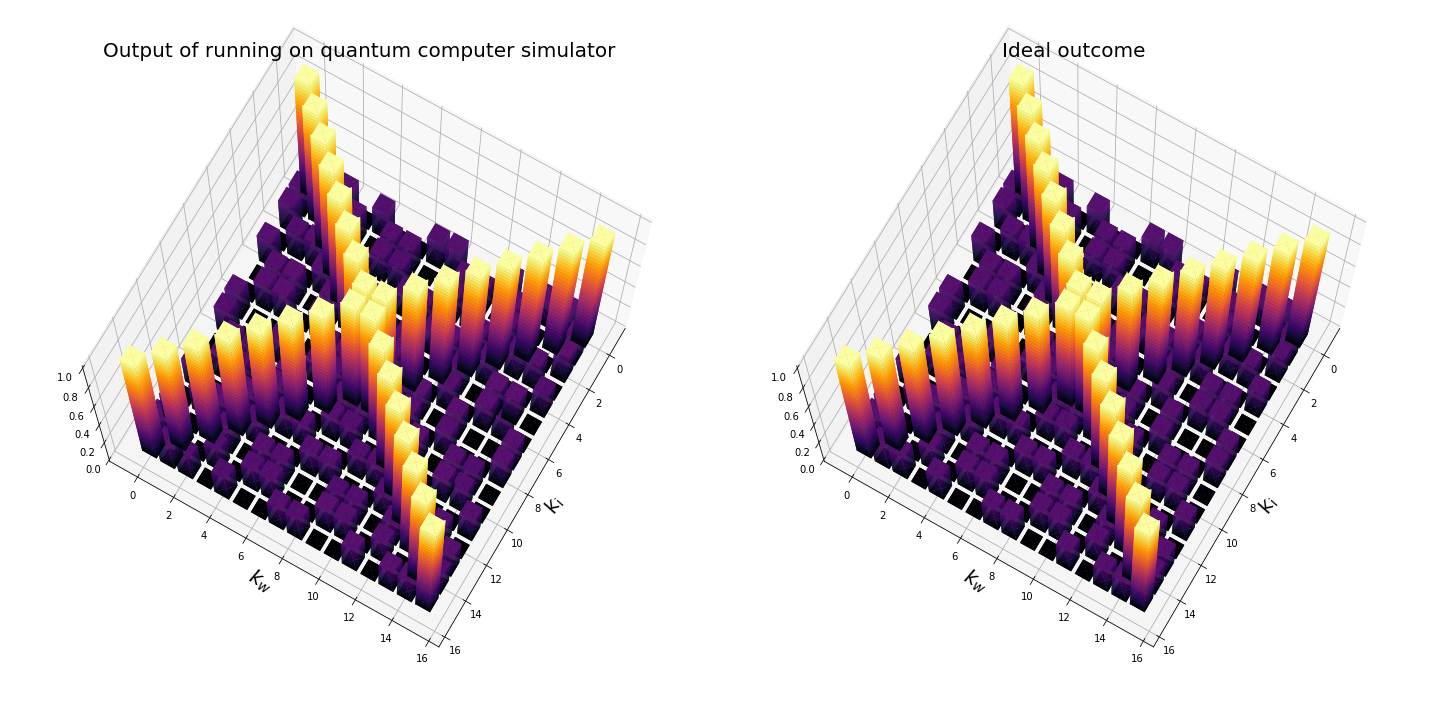

In [29]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(121, projection= Axes3D.name)
ax.view_init(75, 30)
make_bars(ax, _xx,_yy,quantum_ans, width=0.4, )
plt.xlabel('$k_i$', fontsize = 20)
plt.ylabel('$k_w$', fontsize = 20)
plt.title('Output of running on quantum computer simulator', fontsize = 20)
plt.tight_layout()

ax = fig.add_subplot(122, projection= Axes3D.name)
ax.view_init(75, 30)
make_bars(ax, _xx,_yy,classical_ans, width=0.4, )
plt.xlabel('$k_i$', fontsize = 20)
plt.ylabel('$k_w$', fontsize = 20)
plt.title('Ideal outcome', fontsize = 20)
plt.tight_layout()

In the figure above, $K_i$ represents the decimal representation of a state. For each input/weight value, we compute the output of the perceptron classically and through the quantum simulator provided by qiskit

#### A distance like metric to compute the error between classical and quantum output

In [30]:
def D_val(v1, v2, N):
    return np.sum(np.abs(v1-v2))/(2**(2**(N+1)))

In [31]:
D_val(classical_ans, quantum_ans, 2)

0.00255546875

## Training

---

Training can be performed classically. An iterative algorithm is given below:

1. Initialize the weights to a random value
2. Iterate over all input and compute output value. If required output and computed output do not match, 
   1. If required output = 1, randomly flip bits that are not matching between weight and input
   2. If required output = 0, randomly flip bits that are matching between weight and input

In [32]:
#generating data
N = 4
low = 0
high = 2**(2**N)
X = np.arange(low, high, 1)
y = np.ones_like(X)
y[:int(high/2)] *= 0
# idxs = np.random.randint(0,high,int(high/2))
# y[idxs] *= 0

#initialize weight
weight = np.random.randint(0,2,2**N)
weight = 2*weight - 1

#learning rate
ln = 2

np.random.shuffle(X)

for i,x in enumerate(X):
    x_bin = num2bin(x, 2**N)
    op = predict(x_bin, weight)
    if(op == 1 and y[i] == 0):
        
        idxs = np.where(x_bin == weight)[0]
        if(idxs.size >= ln):
            idxs = np.random.choice(idxs, ln)
            weight[idxs] = weight[idxs]*-1
            
    if(op == 0 and y[i] == 1):

        idxs = np.where(x_bin != weight)[0]
        if(idxs.size >= ln):
            idxs = np.random.choice(idxs, ln)
            weight[idxs] = weight[idxs]*-1

In [33]:
weight

array([-1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1])

In [34]:
y_pred = np.zeros_like(y)
for i in range(low,high):
    y_pred[i] = predict(num2bin(X[i],width = 2**N),weight)[0]

In [0]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Conclusion
---

For N qbits, our encoding mechanism can encode $2^{2^N}$ possible states. This is the main advantage of using quantum computers for implementing perceptrons. As we have shown, the output is very similar to that in the classical case